# Titanic experiments
In this notebook, we apply the 4 different types of hierarchical shrinkage using a single decision tree on the titanic dataset, with the (uninformative) feature `PassengerID` included. For each type of shrinkage, we inspect average test set accuracy using 10-fold CV and the feature importances for varying values of lambda.

The main expectation is that the MDI feature importance for `PassengerID` will be much lower for models with shrinkage than without.

In [1]:
from aughs import ShrinkageClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from titanic import preprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

This function computes balanced accuracy scores and feature importances for all lambdas on one split of the dataset. We put this in a separate function so that we can compute all folds in parallel later.

In [2]:
def compute_scores_single_fold(train_index, test_index, X, y, lmbs, shrink_mode):
    scores = []
    importances = []

    clf = ShrinkageClassifier(shrink_mode=shrink_mode)
    clf.fit(X[train_index], y[train_index])
    for lmb in lmbs:
        clf.set_shrink_params(X[train_index], shrink_mode=shrink_mode, lmb=lmb)
        scores.append(balanced_accuracy_score(y[test_index], clf.predict(X[test_index])))
        importances.append(clf.estimator_.feature_importances_)
    return scores, importances

In the cell below, we split the data into 10 folds, and for each 9-1-fold split, we compute balanced accuracy and feature importances for lambda ranging from 1 to 100. Each of these splits is computed in parallel using joblib.

In [3]:
X_df, y_df = preprocess(pd.read_csv("../raw_data/titanic/titanic_train.csv"))
lmbs = np.arange(0, 100, 1)
scores = {}
importances = {}
for shrink_mode in ["hs", "hs_entropy", "hs_log_cardinality"]:
    cv = KFold(n_splits=10, shuffle=True)
    results = Parallel(n_jobs=-1)(
        delayed(compute_scores_single_fold)(
            train_index, test_index, X_df.values, y_df.values, lmbs, shrink_mode)
            for train_index, test_index in cv.split(X_df.values))
    shrink_mode_scores = np.vstack([result[0] for result in results])
    shrink_mode_importances = np.array([result[1] for result in results])
    scores[shrink_mode] = shrink_mode_scores
    importances[shrink_mode] = np.average(shrink_mode_importances, axis=0)

The cell below shows the average and standard deviation of the balanced accuracy across the 10 splits for each shrinkage method and lambda value. We can see that the performance varies wildly across the folds, and no method is significantly better than any other.

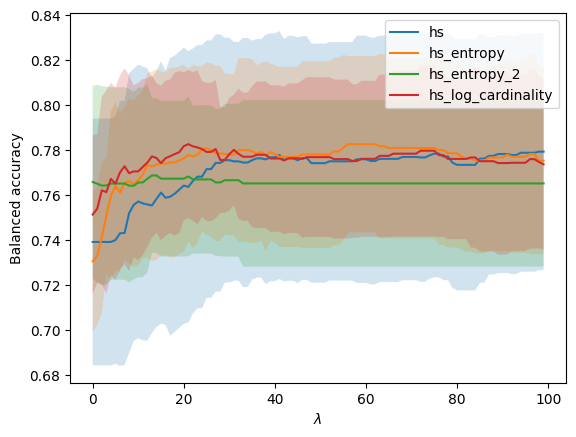

In [4]:
for key in scores:
    avg = np.average(scores[key], axis=0)
    std = np.std(scores[key], axis=0)
    plt.plot(lmbs, avg, label=key)
    plt.fill_between(lmbs, avg-std, avg+std, alpha=0.2)
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("Balanced accuracy")
plt.show()

In the cell below, we look at the feature importances for each type of shrinkage as a function of lambda. We see that all types of augmented shrinkage have a stronger influence on PassengerID, as expected.

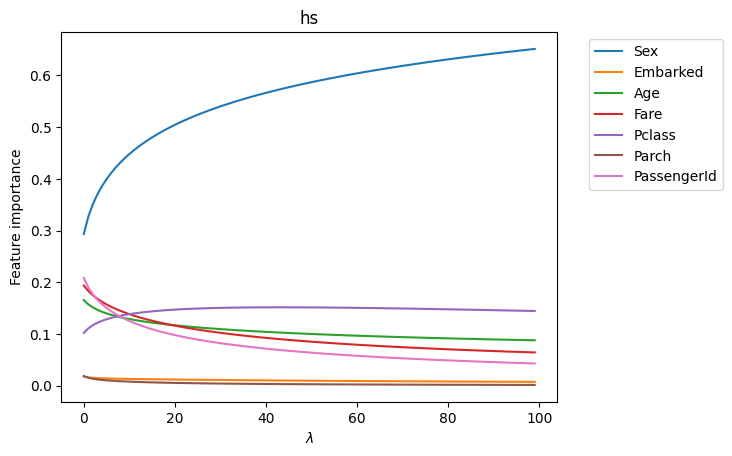

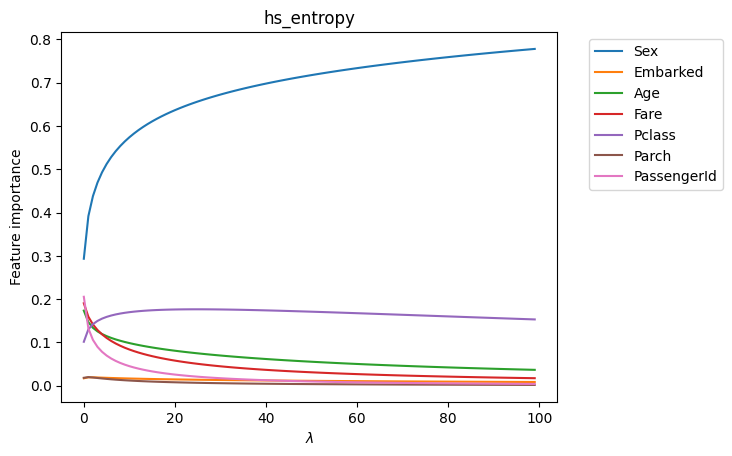

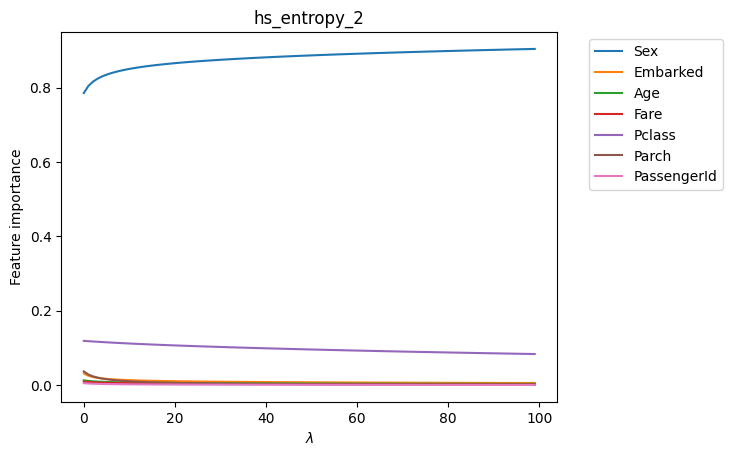

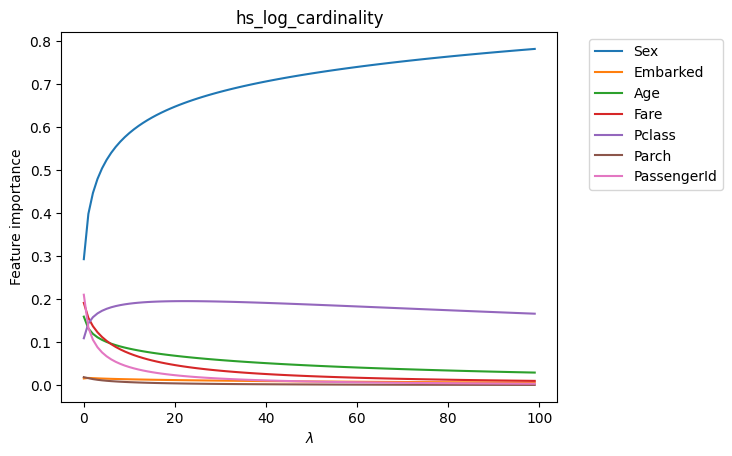

In [5]:
for key in importances:
    line_objects = plt.plot(lmbs, importances[key])
    plt.legend(line_objects, X_df.columns, bbox_to_anchor=(1.05, 1))
    plt.title(key)
    plt.xlabel("$\lambda$")
    plt.ylabel("Feature importance")
    plt.show()